# 🖼️ **ColorLandScape GAN** 🌄

Welcome to **ColorLandScape GAN**, a cutting-edge Generative Adversarial Network (GAN) that generates stunning and realistic landscape images. This project demonstrates how a generator and a discriminator work together to produce mesmerizing images that resemble natural landscapes.

---

## **Overview of ColorLandScape GAN**

This project is designed to create realistic landscape images using GANs. The generator creates images from random noise, while the discriminator differentiates between real and generated images. With each iteration, the generator improves, learning to create better, more realistic landscapes. 

![ColorLandScape GAN GIF](https://media1.giphy.com/media/bzSLg0iH94fSw/giphy.webp?cid=ecf05e47p0hbh0t3yuccf487rjv8v345i462kww4xno6t92t&ep=v1_gifs_search&rid=giphy.webp&ct=g)  
---

## **How It Works**

### 1. **Generator Architecture**
The **Generator** model is a neural network that takes random noise as input and generates high-quality landscape images. It uses an encoder-decoder architecture with downsampling and upsampling layers to recreate images at progressively higher resolutions.

- **Input**: Random noise vector
- **Output**: A fully generated landscape image

### 2. **Discriminator Architecture**
The **Discriminator** model evaluates whether an image is real or generated. It takes both real and generated images as input and uses convolution layers to classify them.

- **Input**: Real and generated landscape images
- **Output**: Probability that the image is real

---

## 📊 **Training Process**

### **Adversarial Loss**  
The training uses adversarial loss, where the **Generator** tries to fool the **Discriminator** into thinking the generated images are real. The **Discriminator** continuously learns to differentiate between real and fake images, leading to progressively better results.

---

In [1]:
import torch
print("Torch CUDA available:", torch.cuda.is_available())
print("GPU Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU detected")

Torch CUDA available: True
GPU Name: Tesla T4


In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2025-05-12 07:56:36.323249: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747036596.545305      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747036596.611384      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Num GPUs Available:  2


In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import tensorflow as tf
from tensorflow import keras
from keras import layers
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from tqdm import tqdm
import re
from keras.preprocessing.image import img_to_array
import time

In [4]:
# Sort files alphanumerically
def sorted_alphanumeric(data):  
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key=alphanum_key)

In [5]:
# Constants
SIZE = 256
LAMBDA = 100
color_img, gray_img = [], []

# Load images
def load_images(path, limit='2200.jpg'):
    images = []
    files = sorted_alphanumeric(os.listdir(path))
    for i in tqdm(files):
        if i == limit:
            break
        img = cv2.imread(os.path.join(path, i), 1)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (SIZE, SIZE))
        img = img.astype('float32') / 255.0
        images.append(img_to_array(img))
    return images

In [6]:
# Paths 
color_path = '/kaggle/input/landscape-image-colorization/landscape Images/color'
gray_path = '/kaggle/input/landscape-image-colorization/landscape Images/gray'

color_img = load_images(color_path)
gray_img = load_images(gray_path)

# Convert to TensorFlow Datasets
color_dataset = tf.data.Dataset.from_tensor_slices(np.array(color_img[:2000])).batch(64)
gray_dataset = tf.data.Dataset.from_tensor_slices(np.array(gray_img[:2000])).batch(64)
color_dataset_t = tf.data.Dataset.from_tensor_slices(np.array(color_img[2000:])).batch(8)
gray_dataset_t = tf.data.Dataset.from_tensor_slices(np.array(gray_img[2000:])).batch(8)

# Image plotting
def plot_images(a=4):
    example_color = next(iter(color_dataset))
    example_gray = next(iter(gray_dataset))
    for i in range(a):
        plt.figure(figsize=(10,10))
        plt.subplot(121)
        plt.title('Color')
        plt.imshow(example_color[i])
        plt.subplot(122)
        plt.title('Gray')
        plt.imshow(example_gray[i])
        plt.show()

 31%|███       | 2200/7129 [00:16<00:38, 129.48it/s]
I0000 00:00:1747036644.218240      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1747036644.218968      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


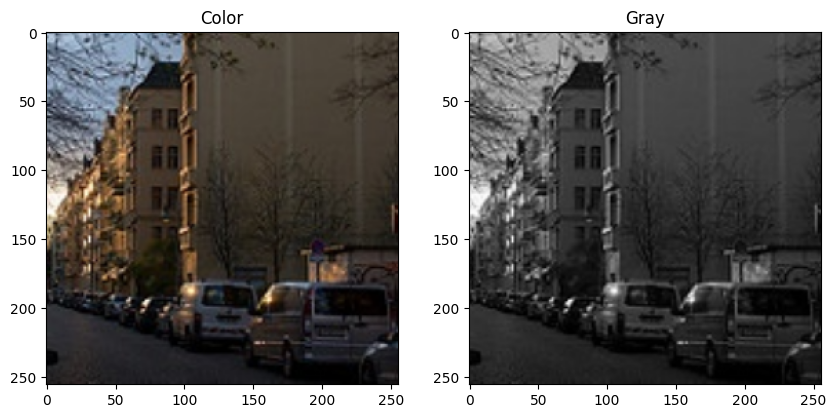

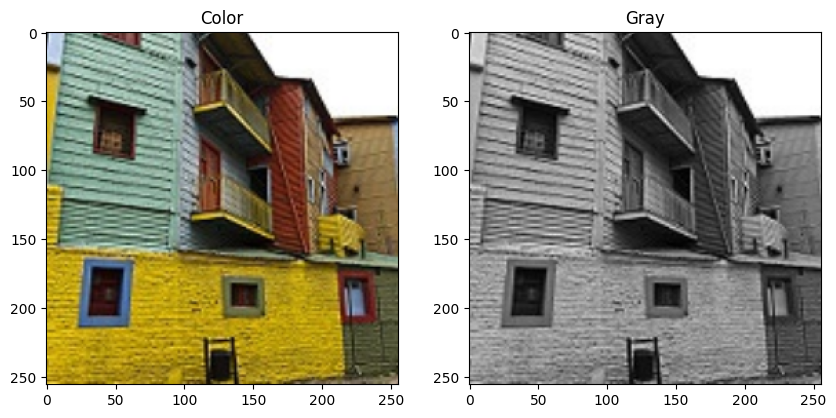

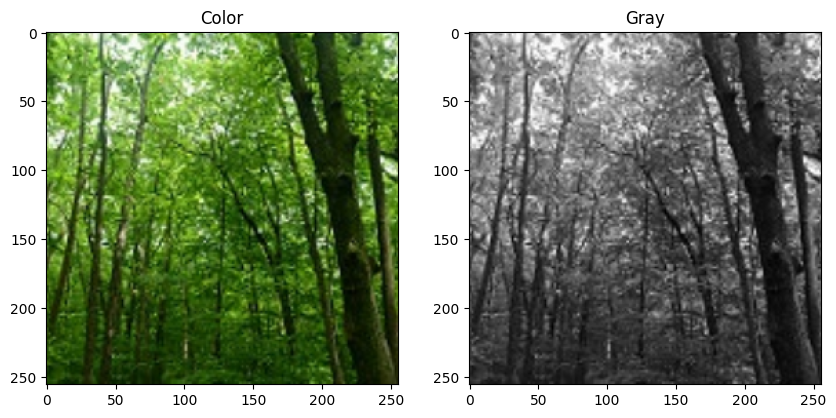

In [7]:
plot_images(3)

In [8]:
# Downsample and upsample layers
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                                      kernel_initializer=initializer, use_bias=False))
    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())
    result.add(tf.keras.layers.LeakyReLU())
    return result

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                               padding='same', kernel_initializer=initializer, use_bias=False))
    result.add(tf.keras.layers.BatchNormalization())
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))
    result.add(tf.keras.layers.ReLU())
    return result

In [9]:
def Generator():
    inputs = tf.keras.layers.Input(shape=[256, 256, 3])
    down_stack = [downsample(64, 4, apply_batchnorm=False), downsample(128, 4), downsample(256, 4),
                  downsample(512, 4), downsample(512, 4), downsample(512, 4),
                  downsample(512, 4), downsample(512, 4)]
    up_stack = [upsample(512, 4, apply_dropout=False), upsample(512, 4, apply_dropout=False),
                upsample(512, 4, apply_dropout=False), upsample(512, 4),
                upsample(256, 4), upsample(128, 4), upsample(64, 4)]  # Disable Dropout
    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(3, 4, strides=2, padding='same',
                                           kernel_initializer=initializer, activation='tanh')

    x = inputs
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    skips = reversed(skips[:-1])
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])
    x = last(x)
    return tf.keras.Model(inputs=inputs, outputs=x)


# Discriminator Model
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
    tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')
    x = tf.keras.layers.concatenate([inp, tar])
    down1 = downsample(64, 4, False)(x)
    down2 = downsample(128, 4)(down1)
    down3 = downsample(256, 4)(down2)
    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer, use_bias=False)(zero_pad1)
    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)
    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)
    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)
    last = tf.keras.layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(zero_pad2)
    return tf.keras.Model(inputs=[inp, tar], outputs=last)

In [10]:
# Loss and optimizer
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    total_gen_loss = gan_loss + (LAMBDA * l1_loss)
    return total_gen_loss, gan_loss, l1_loss

def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
    return real_loss + generated_loss

In [11]:
# Model initialization
generator = Generator()
discriminator = Discriminator()

In [12]:
generator.summary()
discriminator.summary()

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential (Sequential)   │ (None, 128, 128, 64)   │          3,072 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_1 (Sequential) │ (None, 64, 64, 128)    │        131,584 │ sequential[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_2 (Sequential) │ (None, 32, 32, 256)    │        525,312 │ sequential_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_3 (Sequential) │ (None, 16, 16, 512)    │      2,099,200 │ sequential_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_4 (Sequential) │ (None, 8, 8, 512)      │      4,196,352 │ sequential_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_5 (Sequential) │ (None, 4, 4, 512)      │      4,196,352 │ sequential_4[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_6 (Sequential) │ (None, 2, 2, 512)      │      4,196,352 │ sequential_5[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_7 (Sequential) │ (None, 1, 1, 512)      │      4,196,352 │ sequential_6[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_8 (Sequential) │ (None, 2, 2, 512)      │      4,196,352 │ sequential_7[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 2, 2, 1024)     │              0 │ sequential_8[0][0],    │
│                           │                        │                │ sequential_6[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_9 (Sequential) │ (None, 4, 4, 512)      │      8,390,656 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 4, 4, 1024)     │              0 │ sequential_9[0][0],    │
│ (Concatenate)             │                        │                │ sequential_5[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_10             │ (None, 8, 8, 512)      │      8,390,656 │ concatenate_1[0][0]    │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2             │ (None, 8, 8, 1024)     │              0 │ sequential_10[0][0],   │
│ (Concatenate)             │                        │                │ sequential_4[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_11             │ (None, 16, 16, 512)    │      8,390,656 │ concatenate_2[0][0]    │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_3             │ (None, 16, 16, 1024)   │              0 │ sequential_11[0][0],   │
│ (Concatenate)        

 Total params: 54,425,859 (207.62 MB)

 Trainable params: 54,414,979 (207.58 MB)

 Non-trainable params: 10,880 (42.50 KB)

Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ target_image (InputLayer) │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_7             │ (None, 256, 256, 6)    │              0 │ input_image[0][0],     │
│ (Concatenate)             │                        │                │ target_image[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_15             │ (None, 128, 128, 64)   │          6,144 │ concatenate_7[0][0]    │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_16             │ (None, 64, 64, 128)    │        131,584 │ sequential_15[0][0]    │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_17             │ (None, 32, 32, 256)    │        525,312 │ sequential_16[0][0]    │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d            │ (None, 34, 34, 256)    │              0 │ sequential_17[0][0]    │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_11 (Conv2D)        │ (None, 31, 31, 512)    │      2,097,152 │ zero_padding2d[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_16    │ (None, 31, 31, 512)    │          2,048 │ conv2d_11[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_11            │ (None, 31, 31, 512)    │              0 │ batch_normalization_1… │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_1          │ (None, 33, 33, 512)    │              0 │ leaky_re_lu_11[0][0]   │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_12 (Conv2D)        │ (None, 30, 30, 1)      │          8,193 │ zero_padding2d_1[0][0] │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,770,433 (10.57 MB)

 Trainable params: 2,768,641 (10.56 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [13]:
# Loss tracking
gen_losses = []
disc_losses = []

In [14]:
# Training step
@tf.function
def train_step(input_image, target, epoch):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)
        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)
        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)
    generator_gradients = gen_tape.gradient(gen_total_loss, generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))
    return gen_total_loss, disc_loss

# Fit function with loss visualization
def fit(train_ds, epochs):
    for epoch in range(epochs):
        start = time.time()
        print("Epoch:", epoch + 1)
        for n, (input_image, target) in train_ds.enumerate():
            gen_total_loss, disc_loss = train_step(input_image, target, epoch)
            gen_losses.append(gen_total_loss.numpy())
            disc_losses.append(disc_loss.numpy())
        print(f"Time taken for epoch {epoch + 1} is {time.time() - start:.2f} sec\n")

    # Plot loss graphs
    plt.figure(figsize=(10, 5))
    plt.plot(gen_losses, label='Generator Loss')
    plt.plot(disc_losses, label='Discriminator Loss')
    plt.xlabel("Training steps")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Generator and Discriminator Loss")
    plt.show()

In [15]:
# Generate images
def generate_images(model, test_input, tar):
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15, 15))
    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i])
        plt.axis('off')
    plt.show()

Epoch: 1


I0000 00:00:1747036674.516701      60 cuda_dnn.cc:529] Loaded cuDNN version 90300


Time taken for epoch 1 is 105.81 sec

Epoch: 2
Time taken for epoch 2 is 86.60 sec

Epoch: 3
Time taken for epoch 3 is 87.01 sec

Epoch: 4
Time taken for epoch 4 is 86.63 sec

Epoch: 5
Time taken for epoch 5 is 87.56 sec

Epoch: 6
Time taken for epoch 6 is 86.87 sec

Epoch: 7
Time taken for epoch 7 is 86.98 sec

Epoch: 8
Time taken for epoch 8 is 87.38 sec

Epoch: 9
Time taken for epoch 9 is 87.14 sec

Epoch: 10
Time taken for epoch 10 is 87.43 sec



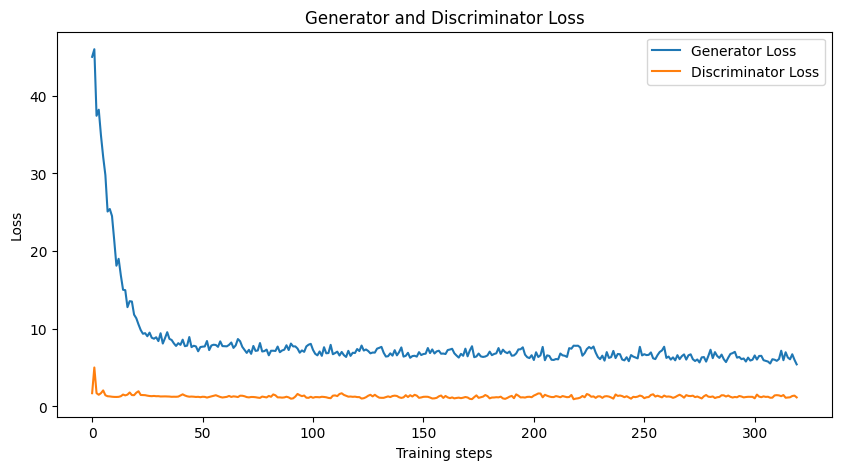

In [16]:
# Start training
fit(tf.data.Dataset.zip((gray_dataset, color_dataset)), epochs=10)

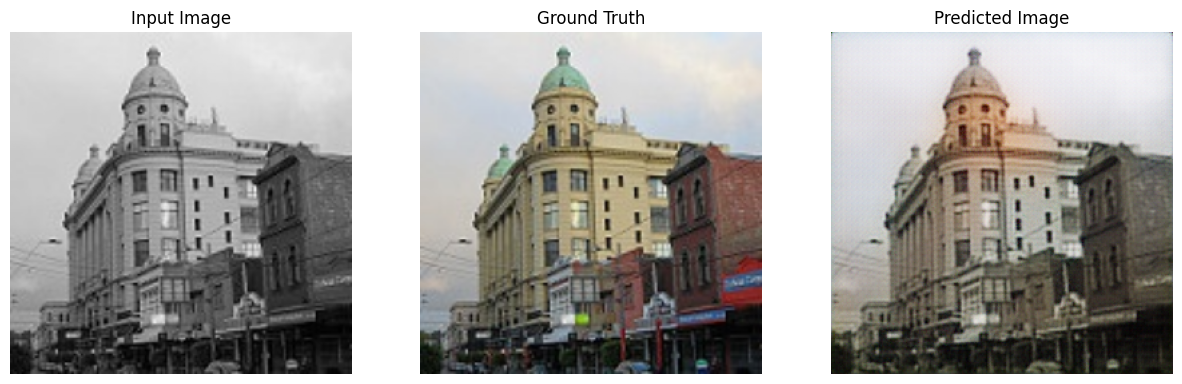

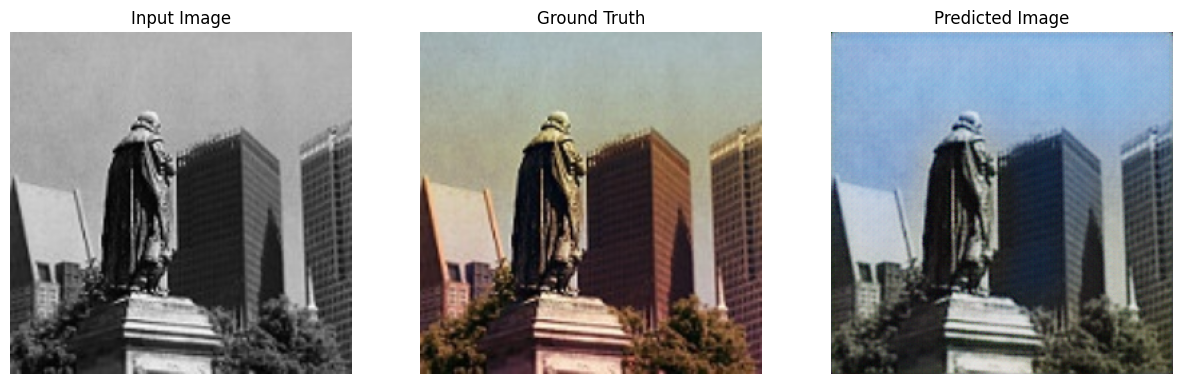

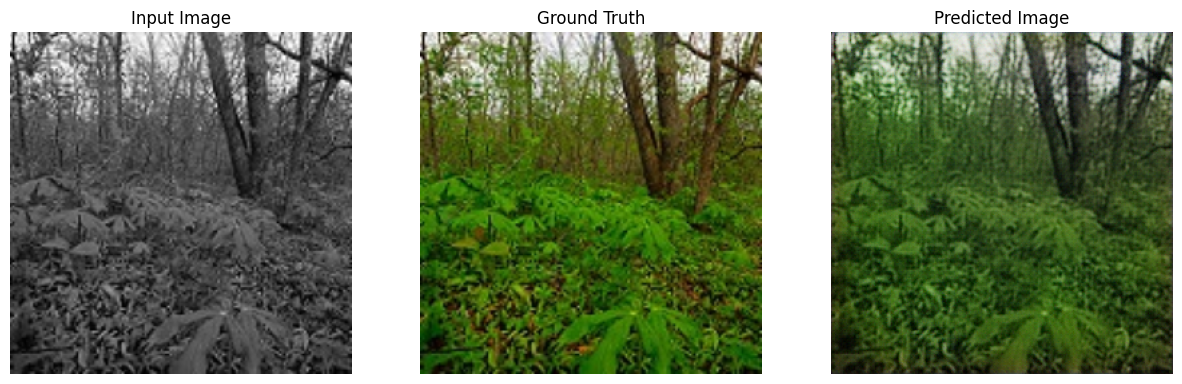

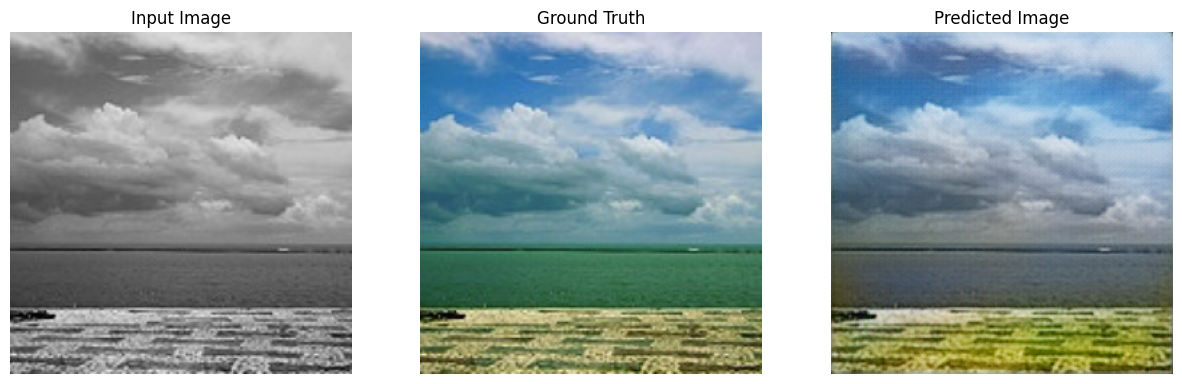

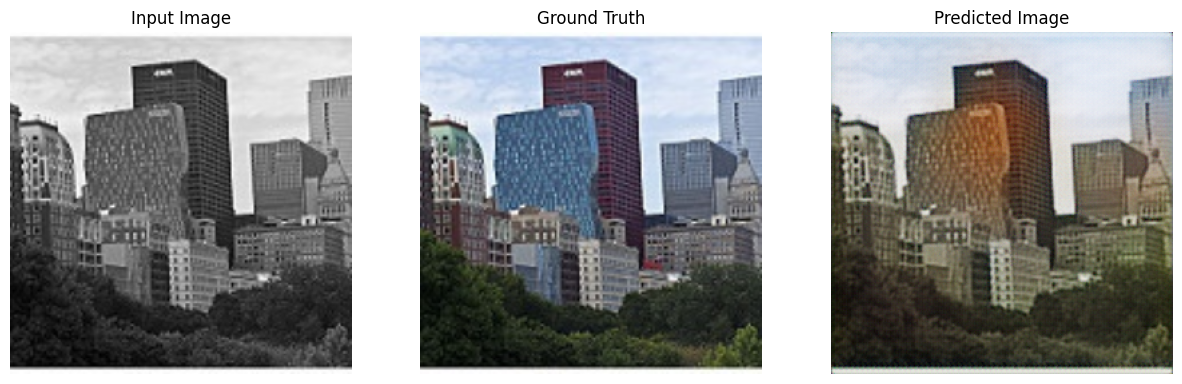

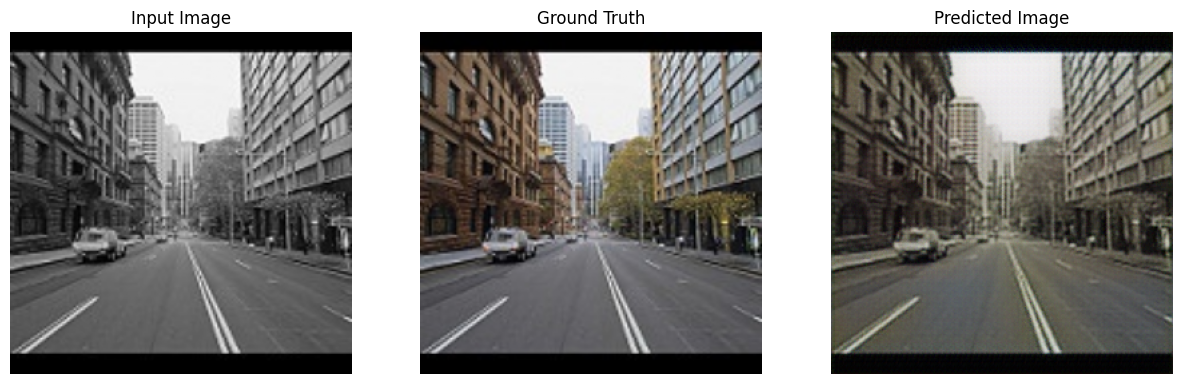

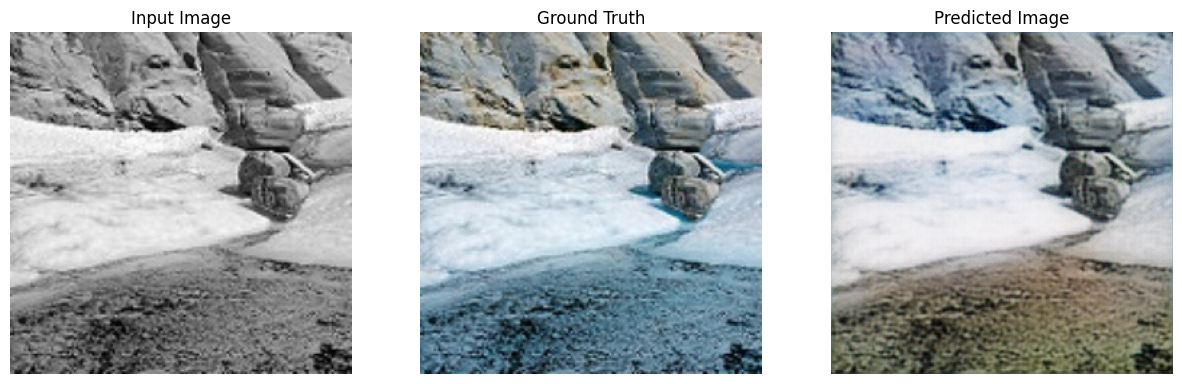

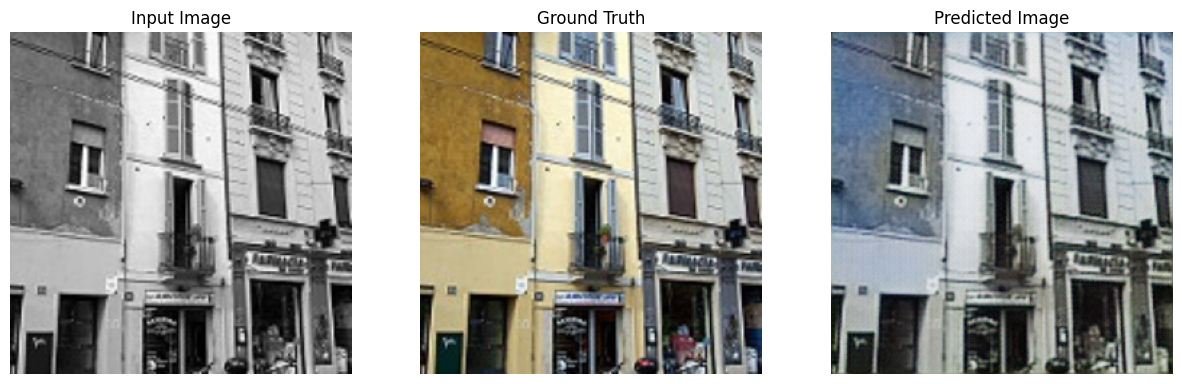

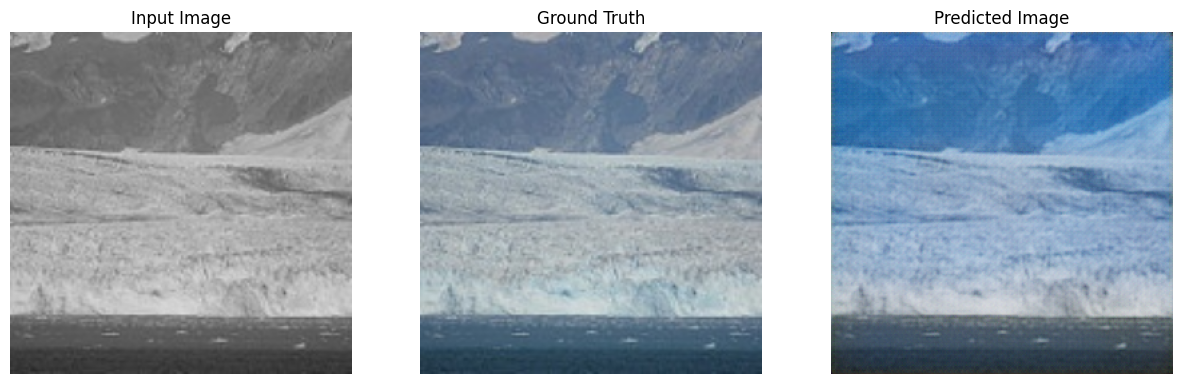

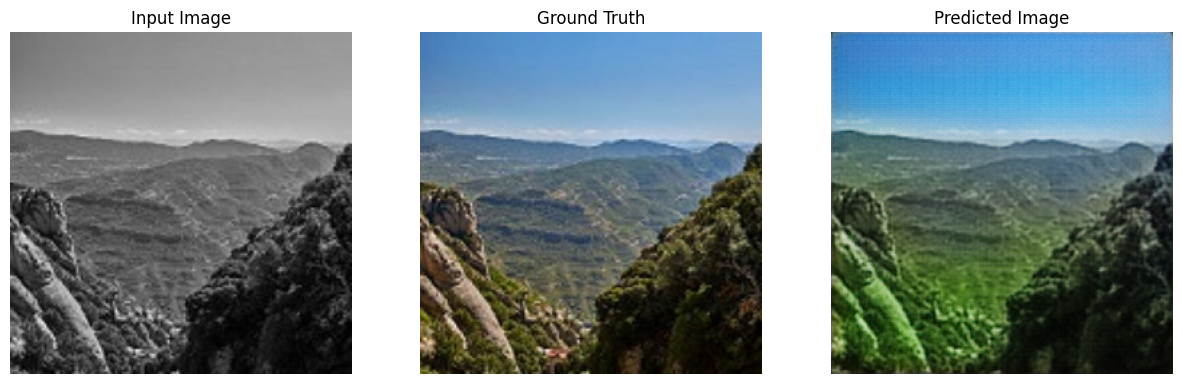

In [17]:
# Display results on test set
for example_input, example_target in tf.data.Dataset.zip((gray_dataset_t, color_dataset_t)).take(10):
    generate_images(generator, example_input, example_target)